## RFM Based Customer Segmentation

In [60]:
%pwd

'c:\\Users\\VenuraP\\Desktop\\Browns-Data-Projects\\RFM Based Customer Segmentation\\notebooks'

In [61]:
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import plotly.offline as pyoff
import plotly.graph_objs as go

In [62]:
# Date
# Settings
import warnings
import datetime as dt
import pandas as pd
df = pd.read_excel('..\data\online_retail_II.xlsx')
df.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525460,538171,21931,JUMBO STORAGE BAG SUKI,2,2010-12-09 20:01:00,1.95,17530.0,United Kingdom


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


## Data Exploration

In [64]:
# Removing returned products (Invoice numbers starting with C) from the data set
df = df[~df["Invoice"].str.contains("C", na = False)]

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515255 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      515255 non-null  object        
 1   StockCode    515255 non-null  object        
 2   Description  512327 non-null  object        
 3   Quantity     515255 non-null  int64         
 4   InvoiceDate  515255 non-null  datetime64[ns]
 5   Price        515255 non-null  float64       
 6   Customer ID  407695 non-null  float64       
 7   Country      515255 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 35.4+ MB


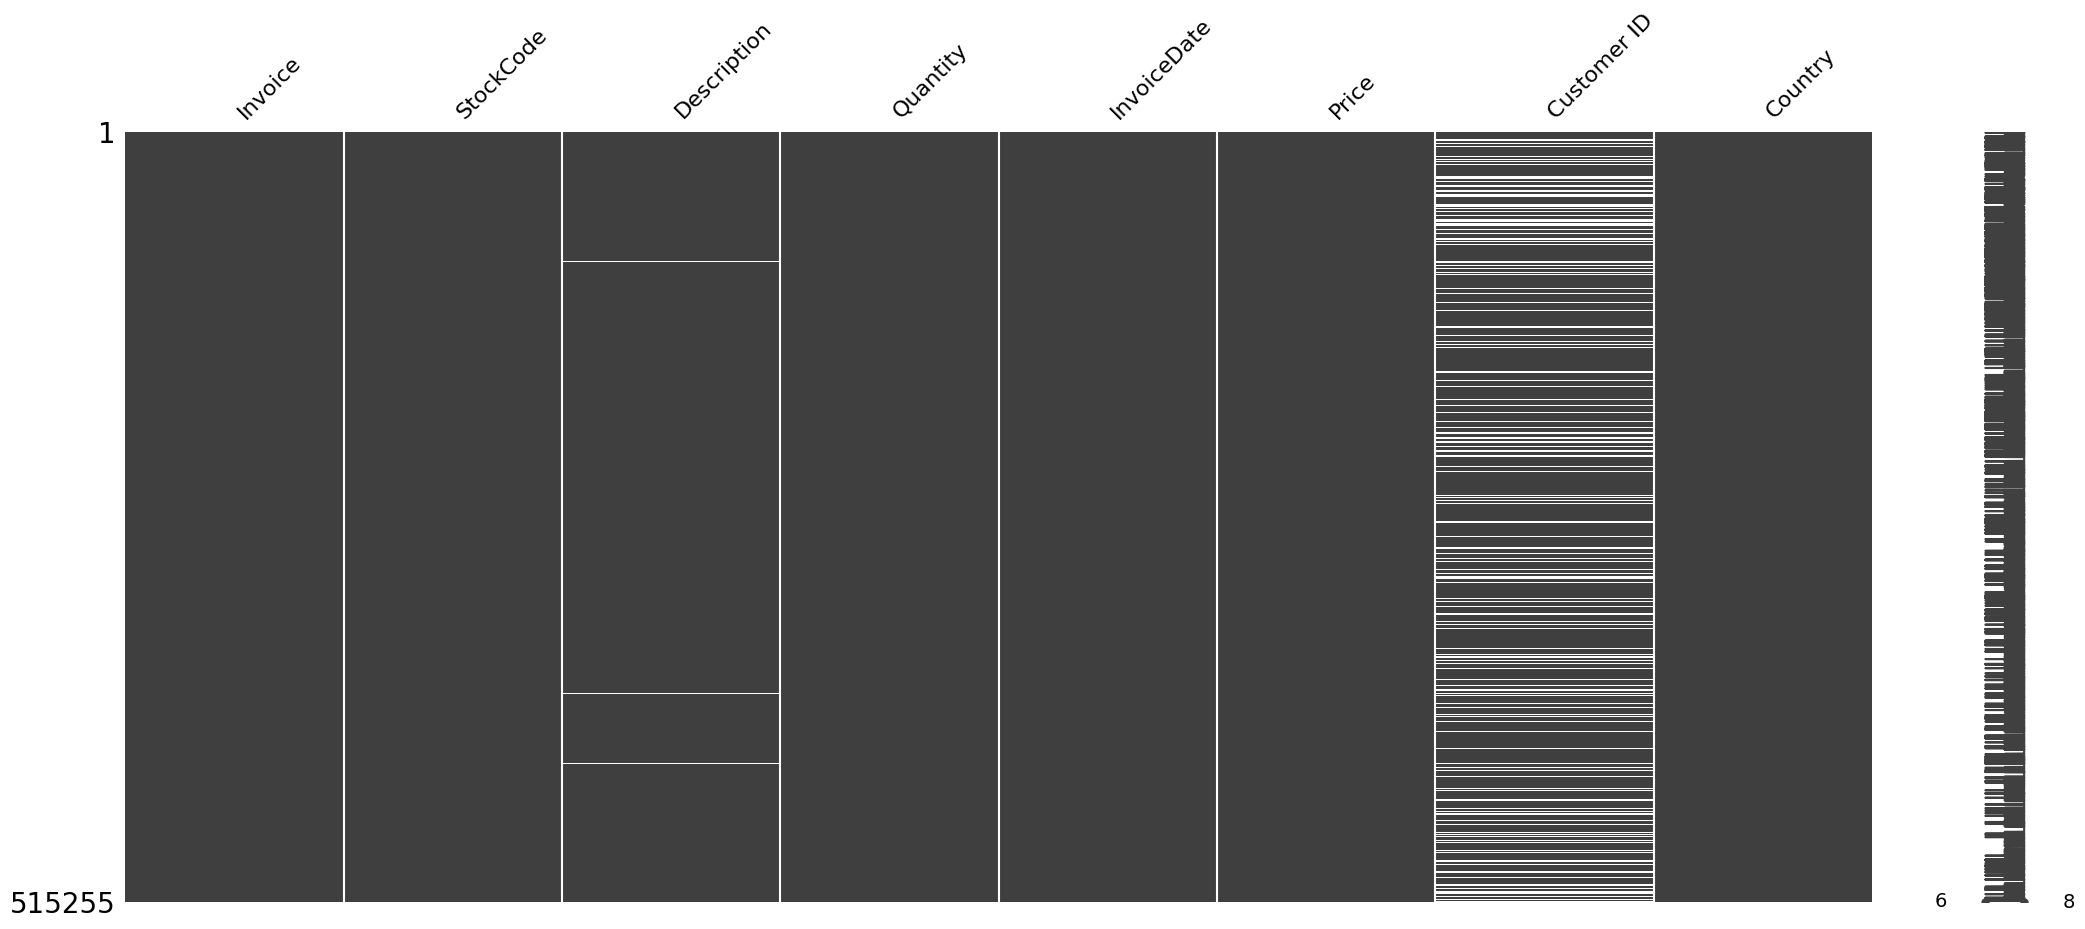

In [66]:
import matplotlib.pyplot as plt
import missingno as msno

# Matrix visualization of NaN values
msno.matrix(df)
plt.show()

In [67]:
# Viewing rows where 'Description' column is NaN
na_description = df[df['Description'].isna()]
na_description.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.0,NaN,United Kingdom
3114,489655,20683,NaN,-44,2009-12-01 17:26:00,0.0,NaN,United Kingdom
3161,489659,21350,NaN,230,2009-12-01 17:39:00,0.0,NaN,United Kingdom
3731,489781,84292,NaN,17,2009-12-02 11:45:00,0.0,NaN,United Kingdom
4296,489806,18010,NaN,-770,2009-12-02 12:42:00,0.0,NaN,United Kingdom


In [68]:
# Viewing rows where 'Customer ID' column is NaN
na_customer_id = df[df['Customer ID'].isna()]
na_customer_id.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom


In [69]:
df["InvoiceDate"].max() # Last invoice date

Timestamp('2010-12-09 20:01:00')

In [70]:
today_date = dt.datetime(2011,12,9) # last invoice date is assigned to today_date variable
print(today_date)

2011-12-09 00:00:00


In [71]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,515255.000000,515255,515255.000000,407695.000000
mean,10.956631,2010-06-28 17:41:06.558422528,3.956373,15368.504107
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 13:27:00,1.250000,13997.000000
50%,3.000000,2010-07-06 13:13:00,2.100000,15321.000000
75%,10.000000,2010-10-15 14:27:00,4.210000,16812.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,104.354013,NaN,127.688563,1679.795700


In [72]:
df.loc[(df.Price<0)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


In [73]:
df.loc[(df.Quantity<0)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.0,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.0,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.0,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.0,NaN,United Kingdom
3114,489655,20683,NaN,-44,2009-12-01 17:26:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
524458,538092,37467,NaN,-177,2010-12-09 14:49:00,0.0,NaN,United Kingdom
525231,538159,21324,NaN,-18,2010-12-09 17:17:00,0.0,NaN,United Kingdom
525232,538158,20892,NaN,-32,2010-12-09 17:17:00,0.0,NaN,United Kingdom
525234,538161,46000S,Dotcom sales,-100,2010-12-09 17:25:00,0.0,NaN,United Kingdom


### Need to clean above values which doesnt represent the real sales

In [74]:
df.isnull().mean()*100

Invoice         0.000000
StockCode       0.000000
Description     0.568262
Quantity        0.000000
InvoiceDate     0.000000
Price           0.000000
Customer ID    20.875101
Country         0.000000
dtype: float64

### Checking which country has the best representation of customers

In [75]:
df.Country.value_counts(normalize=True) 

Country
United Kingdom          0.925868
EIRE                    0.018360
Germany                 0.014868
France                  0.010736
Netherlands             0.005298
Spain                   0.002397
Switzerland             0.002271
Portugal                0.002059
Belgium                 0.002015
Sweden                  0.001721
Channel Islands         0.001593
Italy                   0.001378
Australia               0.001223
Cyprus                  0.001050
Austria                 0.001017
Greece                  0.000994
Denmark                 0.000811
United Arab Emirates    0.000774
Norway                  0.000708
Finland                 0.000673
Unspecified             0.000594
USA                     0.000446
Poland                  0.000353
Malta                   0.000330
Japan                   0.000318
Lithuania               0.000299
Singapore               0.000227
RSA                     0.000213
Bahrain                 0.000206
Canada                  0.000149
Th

### Since we have 90% of UK customer base we take that for analysis

In [76]:
df=df[df.Country == 'United Kingdom']
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


### Remove Garbage Data

In [77]:
df = df[df.Quantity > 0]
df = df[df.Price > 0]

#Removing the Null values from data.
df = df[pd.notnull(df['Customer ID'])]

In [78]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceYearMonth'] = df['InvoiceDate'].map(lambda date: 100*date.year + date.month)
df['Date'] = df['InvoiceDate'].dt.strftime('%Y-%m')

In [79]:
df.isnull().mean()

Invoice             0.0
StockCode           0.0
Description         0.0
Quantity            0.0
InvoiceDate         0.0
Price               0.0
Customer ID         0.0
Country             0.0
InvoiceYearMonth    0.0
Date                0.0
dtype: float64

### AS we focus on the the RFM analysis we need this data
- Customer ID
- Price
- Qunatity
- Invoice Date

### Aggregating Orders by Month

In [80]:
df_agg= df.groupby("Date").Quantity.sum()
df_agg

Date
2009-12    361783
2010-01    236956
2010-02    235073
2010-03    385372
2010-04    291692
2010-05    328210
2010-06    333286
2010-07    280827
2010-08    314367
2010-09    480331
2010-10    505380
2010-11    555515
2010-12    139781
Name: Quantity, dtype: int64

In [81]:
#converting series to dataframe and resetting index, and changing the column name to 'Orders'
df_agg=pd.DataFrame(df_agg)
df_agg=df_agg.reset_index()
df_agg.head(14)

,Date,Quantity
0,2009-12,361783
1,2010-01,236956
2,2010-02,235073
3,2010-03,385372
4,2010-04,291692
5,2010-05,328210
6,2010-06,333286
7,2010-07,280827
8,2010-08,314367
9,2010-09,480331


In [82]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Orders', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.plot(x, y, color='tab:Blue', marker='o')
    plt.show()

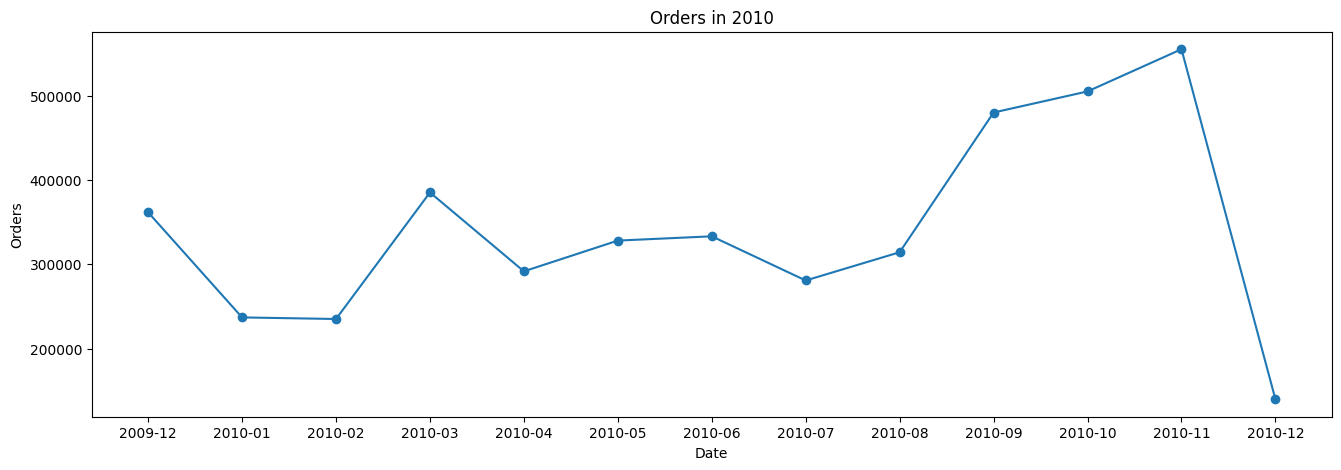

In [83]:
plot_df(df_agg, x=df_agg.Date, y=df_agg.Quantity,title='Orders in 2010')

### Calculating the Revenue on Original Dataset

In [84]:
df['Revenue'] = df['Quantity']*df['Price']

Number of rows in 'Quantity' column: 370929


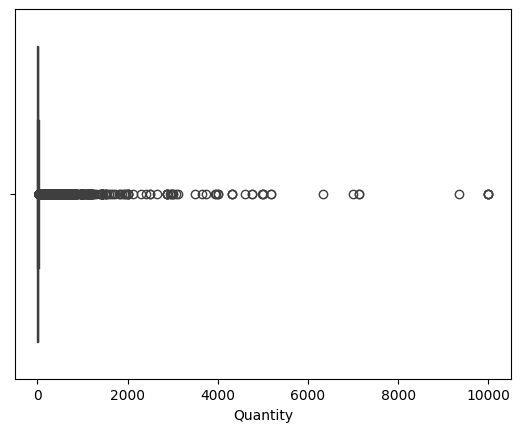

In [85]:
import seaborn as sns

sns.boxplot(x=df['Quantity'])

row_count = len(df['Quantity'])

print("Number of rows in 'Quantity' column:", row_count)

In [86]:
df.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,InvoiceYearMonth,Date,Revenue
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom,201012,2010-12,5.90
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,201012,2010-12,3.75
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,201012,2010-12,3.75
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,201012,2010-12,7.50
525460,538171,21931,JUMBO STORAGE BAG SUKI,2,2010-12-09 20:01:00,1.95,17530.0,United Kingdom,201012,2010-12,3.90


### Monthly Revenue

In [87]:
df_revenue=df.groupby(['InvoiceYearMonth'])['Revenue'].sum().reset_index()
df_revenue.tail()

,InvoiceYearMonth,Revenue
8,201008,508488.090
9,201009,681585.771
10,201010,879189.450
11,201011,983677.132
12,201012,278655.790


In [88]:
plot_data = [
    go.Scatter(
        x=df_revenue['InvoiceYearMonth'],
        y=df_revenue['Revenue'],
        mode='lines+markers'
    )
]
plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

### RFM Analysis

- Recency - Duration since last purchase
- Frequency - Purchasing rate for a specific time period
- Monetary - A total value of purchases a customer has made

** Note (The last invoice date is 2011–12–09, we will use this date to calculate Recency)**

In [89]:
NOW = dt.date(2011,12,9) 
df['Date'] = pd.DatetimeIndex(df.InvoiceDate).date

### Recency

In [90]:
df_recency = df.groupby(['Customer ID'],as_index=False)['Date'].max()
df_recency.columns = ['Customer ID','Last_Purchase_Date']

df_recency['Recency'] = df_recency.Last_Purchase_Date.apply(lambda x:(NOW - x).days)
df_recency.drop(columns=['Last_Purchase_Date'],inplace=True)
df_recency.head()

,Customer ID,Recency
0,12346.0,529
1,12608.0,404
2,12745.0,486
3,12746.0,540
4,12747.0,369


### Frequency - Monetory

In [91]:
FM_Table = df.groupby('Customer ID').agg({'Invoice'   : lambda x:len(x),'Revenue'  : lambda x:x.sum()})
FM_Table.rename(columns = {'Invoice' :'Frequency', 'Revenue':'Monetary'},inplace= True)
FM_Table.head()

,Frequency,Monetary
Customer ID,,
12346.0,33,372.86
12608.0,16,415.79
12745.0,22,723.85
12746.0,17,254.55
12747.0,154,5080.53


### Create the RFM table

In [92]:
RFM_Table = df_recency.merge(FM_Table,left_on='Customer ID',right_on='Customer ID')
RFM_Table.head()

,Customer ID,Recency,Frequency,Monetary
0,12346.0,529,33,372.86
1,12608.0,404,16,415.79
2,12745.0,486,22,723.85
3,12746.0,540,17,254.55
4,12747.0,369,154,5080.53


#### Lets split the metrics into segements using qunatiles.We will assign score from 1 to 4 each Recency and Frequency and Monetary Respectively so 1 is the highest value and 4 is the lowest value. Then Calculate the final RFM value by combining individual scores.

In [93]:
quantiles = RFM_Table.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()

In [94]:
segmented_rfm = RFM_Table.copy()

In [95]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [96]:
segmented_rfm['R_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles))
segmented_rfm['F_quartile'] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles))
segmented_rfm['M_quartile'] = segmented_rfm['Monetary'].apply(FMScore, args=('Monetary',quantiles))
segmented_rfm.head()

,Customer ID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile
0,12346.0,529,33,372.86,4,3,3
1,12608.0,404,16,415.79,2,4,3
2,12745.0,486,22,723.85,3,3,2
3,12746.0,540,17,254.55,4,4,4
4,12747.0,369,154,5080.53,1,1,1


#### Calculating the total RFM score combined

##### RFM_Score = R_quartile + F_quartile + M_quartile

In [97]:
segmented_rfm['RFM_Segment'] = segmented_rfm.R_quartile.map(str)+segmented_rfm.F_quartile.map(str)+segmented_rfm.M_quartile.map(str)

In [98]:
segmented_rfm.head()

,Customer ID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Segment
0,12346.0,529,33,372.86,4,3,3,433
1,12608.0,404,16,415.79,2,4,3,243
2,12745.0,486,22,723.85,3,3,2,332
3,12746.0,540,17,254.55,4,4,4,444
4,12747.0,369,154,5080.53,1,1,1,111


In [99]:
segmented_rfm['RFM_Score'] = segmented_rfm[['R_quartile','F_quartile','M_quartile']].sum(axis=1)

In [100]:
segmented_rfm.head()

,Customer ID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
0,12346.0,529,33,372.86,4,3,3,433,10
1,12608.0,404,16,415.79,2,4,3,243,9
2,12745.0,486,22,723.85,3,3,2,332,8
3,12746.0,540,17,254.55,4,4,4,444,12
4,12747.0,369,154,5080.53,1,1,1,111,3


In [101]:
print("Best Customers: ",len(segmented_rfm[segmented_rfm['RFM_Segment']=='111']))
print('Loyal Customers: ',len(segmented_rfm[segmented_rfm['F_quartile']==1]))
print("Big Spenders: ",len(segmented_rfm[segmented_rfm['M_quartile']==1]))
print('Almost Lost: ', len(segmented_rfm[segmented_rfm['RFM_Segment']=='134']))
print('Lost Customers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='344']))
print('Lost Cheap Customers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='444']))

Best Customers:  378
Loyal Customers:  991
Big Spenders:  992
Almost Lost:  26
Lost Customers:  165
Lost Cheap Customers:  350


In [102]:
segmented_rfm['RFM_Score'].unique()

array([10,  9,  8, 12,  3,  4,  5,  7, 11,  6])

In [103]:
segmented_rfm.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'] }).round(1)

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3           371.8     359.5   8559.2   378
4           384.7     205.1   3636.7   375
5           400.0     134.5   2255.3   379
6           412.0      86.5   1502.4   413
7           424.4      57.9   1098.1   411
8           448.8      41.0    811.3   437
9           455.4      27.5    566.6   434
10          510.4      21.7    353.7   420
11          543.1      15.5    231.7   372
12          614.9       8.3    154.0   350

### K-means to perform RFM (Recency, Frequency, and Monetary) customer segmentation.

In [104]:
## Function to check skewness
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

Recency's: Skew: 1.2880920633710795, : SkewtestResult(statistic=np.float64(26.050103239980473), pvalue=np.float64(1.341727751157263e-149))
Frequency's: Skew: 10.932607923769199, : SkewtestResult(statistic=np.float64(69.33587486401359), pvalue=np.float64(0.0))
Monetary's: Skew: 29.7987696243624, : SkewtestResult(statistic=np.float64(90.46676263113497), pvalue=np.float64(0.0))


C:\Users\VenuraP\AppData\Local\Temp\ipykernel_17540\2589328688.py:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\VenuraP\AppData\Local\Temp\ipykernel_17540\2589328688.py:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\VenuraP\AppData\Local\Temp\ipykernel_17540\2589328688.py:6: UserWarning:



`distpl

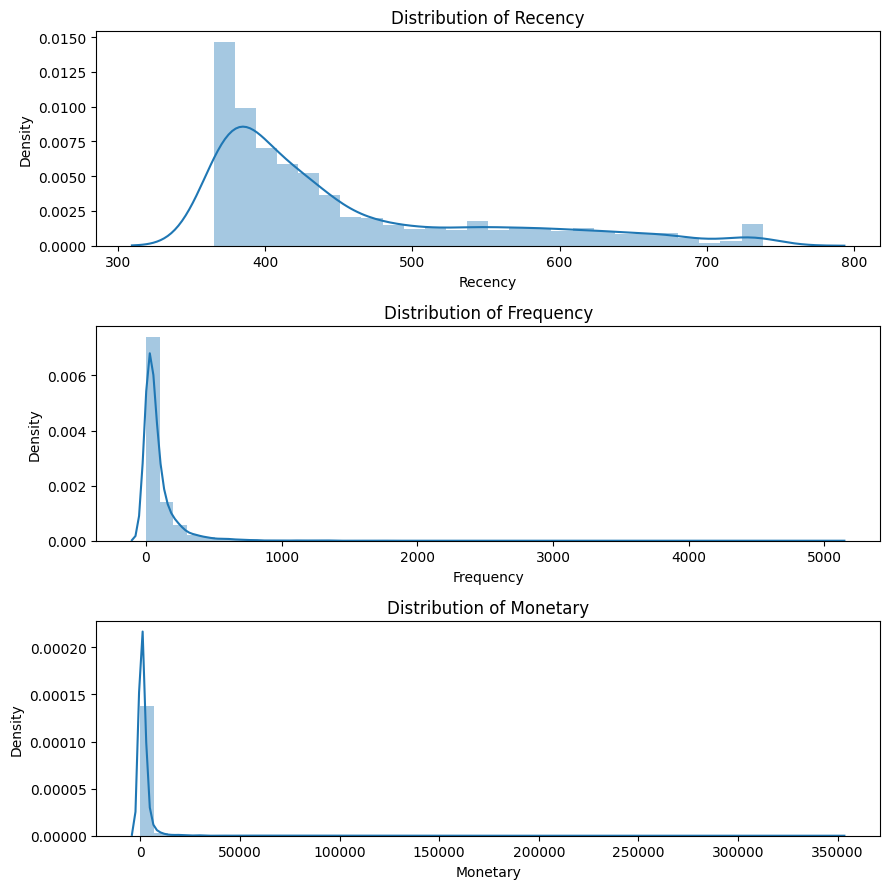

In [105]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(RFM_Table,'Recency')

plt.subplot(3, 1, 2)
check_skew(RFM_Table,'Frequency')

plt.subplot(3, 1, 3)
check_skew(RFM_Table,'Monetary')

plt.tight_layout()

### Data Transformation to reduce the skewness

#### log transform assumes all values to be positive so i added the constant and added the transform to remove the skewness

In [106]:
df_rfm_log = RFM_Table.copy()

In [107]:
df_rfm_log.head()

,Customer ID,Recency,Frequency,Monetary
0,12346.0,529,33,372.86
1,12608.0,404,16,415.79
2,12745.0,486,22,723.85
3,12746.0,540,17,254.55
4,12747.0,369,154,5080.53


C:\Users\VenuraP\AppData\Local\Temp\ipykernel_17540\2589328688.py:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\VenuraP\AppData\Local\Temp\ipykernel_17540\2589328688.py:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\VenuraP\AppData\Local\Temp\ipykernel_17540\2589328688.py:6: UserWarning:



`distpl

Recency's: Skew: 1.033657796191391, : SkewtestResult(statistic=np.float64(22.266100493245606), pvalue=np.float64(7.876478938977165e-110))
Frequency's: Skew: -0.09326323242493806, : SkewtestResult(statistic=np.float64(-2.3980429822500366), pvalue=np.float64(0.016482930948417487))
Monetary's: Skew: 0.2336165504379184, : SkewtestResult(statistic=np.float64(5.941018887002227), pvalue=np.float64(2.8325597357232666e-09))


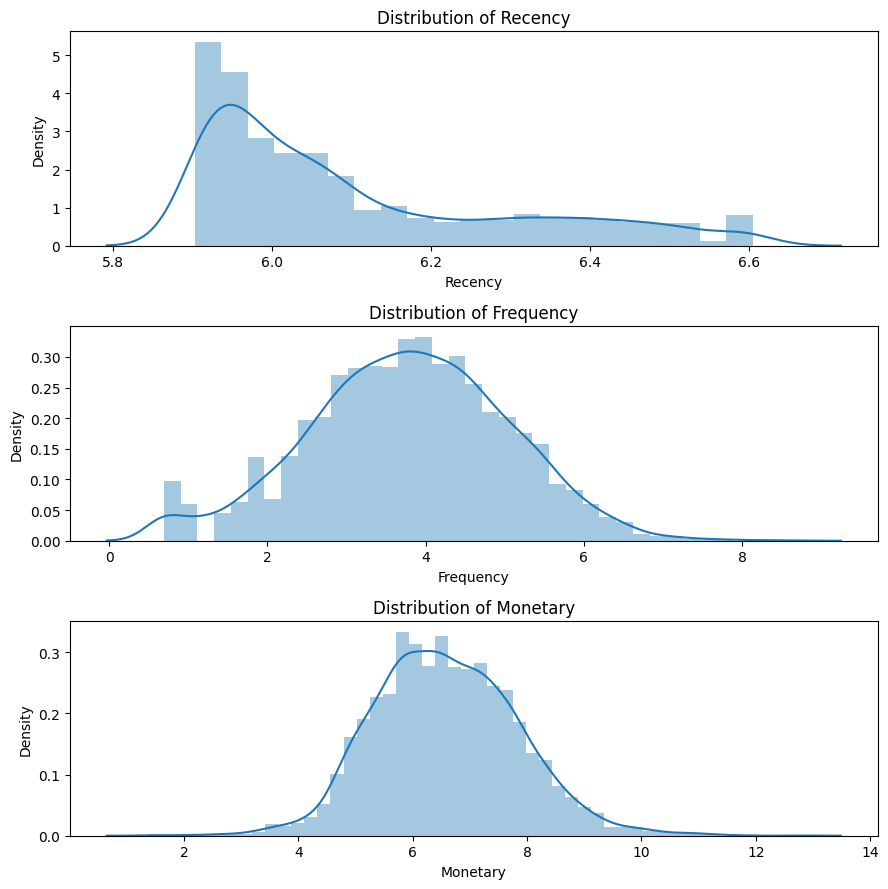

In [108]:
import numpy as np
df_rfm_log = np.log(df_rfm_log+1)  # to make all values positive

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_rfm_log,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_rfm_log,'Frequency')

plt.subplot(3, 1, 3)
check_skew(df_rfm_log,'Monetary')

plt.tight_layout()

In [109]:
RFM_Table.describe()

,Customer ID,Recency,Frequency,Monetary
count,3969.000000,3969.000000,3969.000000,3969.000000
mean,15561.406148,455.095742,93.456538,1868.167287
std,1582.099836,97.072657,183.306124,7380.830030
min,12346.000000,365.000000,1.000000,2.950000
25%,14201.000000,382.000000,18.000000,304.200000
50%,15577.000000,416.000000,43.000000,669.910000
75%,16941.000000,500.000000,102.000000,1655.640000
max,18287.000000,738.000000,5043.000000,349164.350000


In [110]:
# Check data types and missing values
print(df_rfm_log.dtypes)
print(df_rfm_log.isnull().sum())

Customer ID    float64
Recency        float64
Frequency      float64
Monetary       float64
dtype: object
Customer ID    0
Recency        0
Frequency      0
Monetary       0
dtype: int64


### Z Scaling method for remove the Outliers

In [111]:
import numpy as np

# Calculate Z-scores of `df_rfm_log`
z_scores = np.abs((df_rfm_log - df_rfm_log.mean()) / df_rfm_log.std())

# Define a threshold (commonly 3 for being 3 standard deviations away)
threshold = 3

# Remove outliers
df_rfm_log = df_rfm_log[(z_scores < threshold).all(axis=1)]

### Standardize the data by scaling to zero mean and standard deviation of 1 for all the variables

In [112]:
scaler = StandardScaler()

scaler.fit(df_rfm_log)

RFM_Table_scaled = scaler.transform(df_rfm_log)

In [113]:
RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns=df_rfm_log.columns)
RFM_Table_scaled.head()

,Customer ID,Recency,Frequency,Monetary
0,-2.208632,0.878315,-0.195038,-0.531051
1,-2.003616,-0.515842,-0.753573,-0.441272
2,-1.898102,0.439772,-0.509997,0.015782
3,-1.897336,0.984784,-0.707515,-0.845287
4,-1.896570,-0.984296,1.027406,1.624197


### K-Means Clustering
#### Finding the optimal number of clusters

In [114]:
from scipy.spatial.distance import cdist
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(RFM_Table_scaled) 
    kmeanModel.fit(RFM_Table_scaled)     
      
    distortions.append(sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / RFM_Table_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / RFM_Table_scaled.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

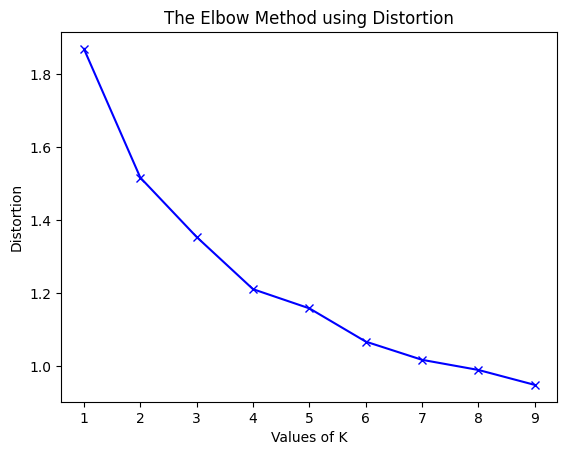

In [115]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

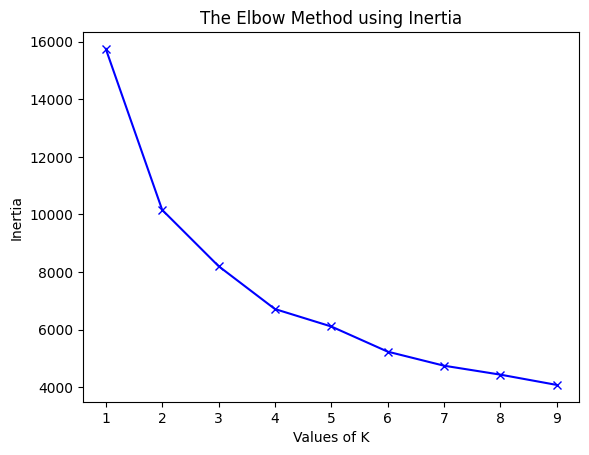

In [116]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

#### Looking at the above elbow curve, we can choose any number of clusters between 4 to 7

In [117]:
def kmeans(normalised_df_rfm, clusters_number):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = normalised_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

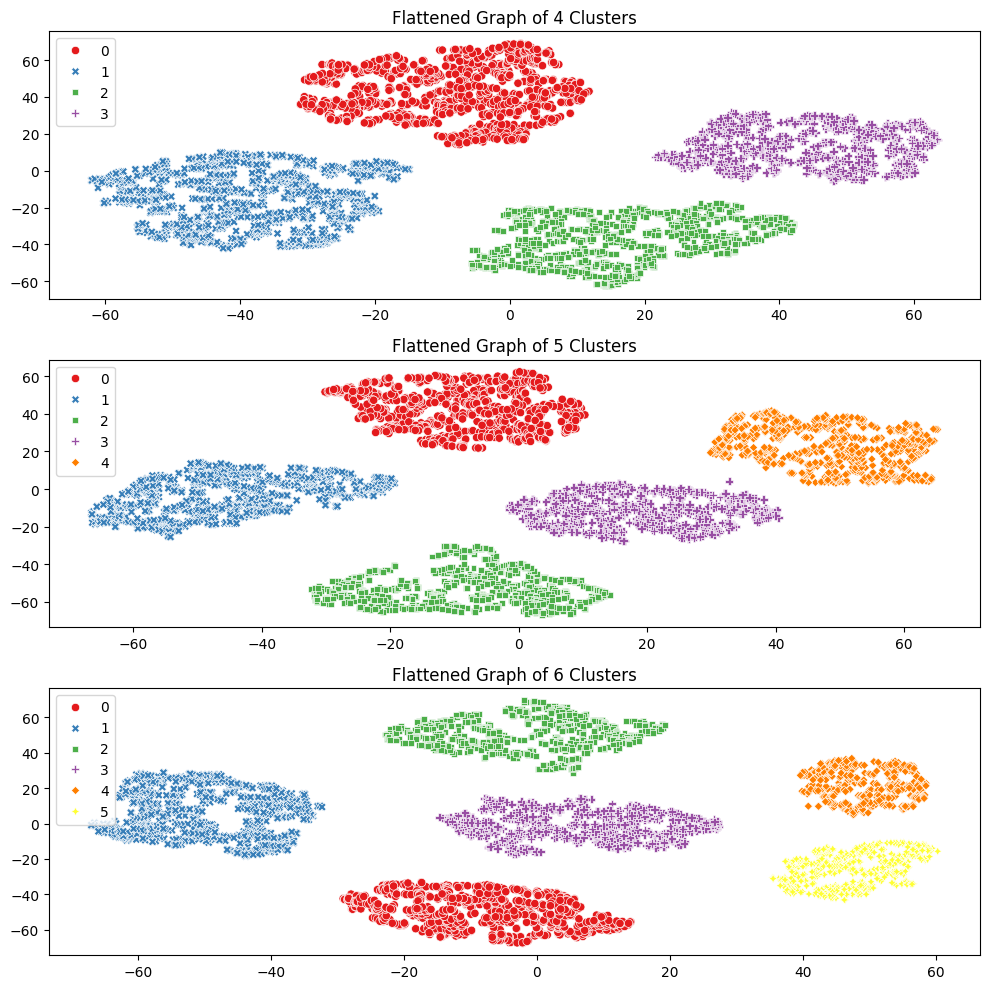

In [124]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k4 = kmeans(RFM_Table_scaled, 4)

plt.subplot(3, 1, 2)
df_rfm_k5 = kmeans(RFM_Table_scaled, 5)

plt.subplot(3, 1, 3)
df_rfm_k6 = kmeans(RFM_Table_scaled, 6)

plt.tight_layout()

In [120]:
### Print table with cluster numbers
df_rfm_k5.head()

,Customer ID,Recency,Frequency,Monetary,Cluster
0,-2.208632,0.878315,-0.195038,-0.531051,3
1,-2.003616,-0.515842,-0.753573,-0.441272,3
2,-1.898102,0.439772,-0.509997,0.015782,3
3,-1.897336,0.984784,-0.707515,-0.845287,3
4,-1.896570,-0.984296,1.027406,1.624197,2


#### Testing Snake Plot

In [127]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans):

    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=RFM_Table.index, 
                                       columns=RFM_Table.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['Customer ID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

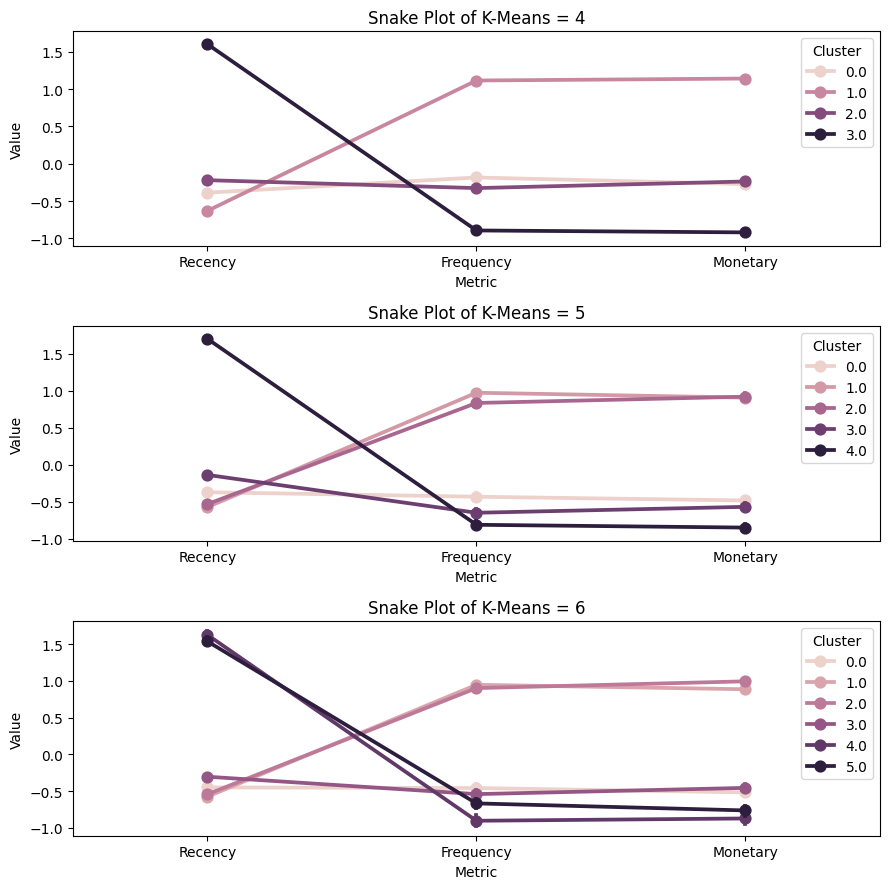

In [128]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 4')
snake_plot(RFM_Table_scaled, df_rfm_k4)
 
plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 5')
snake_plot(RFM_Table_scaled, df_rfm_k5)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 6')
snake_plot(RFM_Table_scaled, df_rfm_k6)

plt.tight_layout()

#### Interpretation of the clusters formed using k-means .

In [129]:
def rfm_values(df):

    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)
    
    return df_new

In [130]:
rfm_values(df_rfm_k4)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          -0.0      -0.0     -0.0  1047
1          -1.0       1.0      1.0  1111
2          -0.0      -0.0     -0.0   958
3           2.0      -1.0     -1.0   822